# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109B Data Science 2: Advanced Topics in Data Science 

## Homewor: Inference in NN 

**Harvard University**<br/>
**Spring 2020**<br/>
**Instructors:** Pavlos Protopapas, Mark Glickman, Chris Tanner<br/>

<hr style="height:2pt">

In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

In [2]:
#RUN THIS CELL
import os
import pathlib
working_dir = pathlib.Path().absolute()
os.chdir(working_dir)

<hr style="height:2pt">

### INSTRUCTIONS

- To submit your assignment follow the instructions given in Canvas.

- This homework can be submitted in pairs.

- Please restart the kernel and run the entire notebook again before you submit.

<hr style="height:2pt">

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# from sklearn.preprocessing import StandardScaler

sns.set()

import tensorflow as tf

import tensorflow.keras.backend as K
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, History 
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
#from tensorflow.keras.utils import np_utils
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import Dropout
from sklearn.model_selection import cross_val_score,  KFold, train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from tensorflow.keras import optimizers

from functools import partial

np.random.seed(0)


%matplotlib notebook
%matplotlib inline

<div class="theme"> Overview </div> 

In this homework, we will investigate methods for uncertainty quantification in deep neural networks. These are alternatives to the robust MCMC that doesn't scale to large models.

<div class='exercise'><b> Question 1: Dropout as a Bayesian Approximation [10 pts] (Gal & Ghahramani 2015, https://arxiv.org/abs/1506.02142)</b></div>  

For this question, we will be generate a synthetic dataset in order to be able to test different uncertainty regimes, we will train the model with a gap in the data. 

**1.1** [1 pt] Generate a synthetic two dimensional dataset using the function y = 0.1 * x^3 plus random noise (0, 0.25). Generate a training set of 200 points with no data in the range x=[-1,1]. Generate a test set of 80 data points with values uniformly distributed in the whole domain. Plot the two data sets.

**1.2** [2 pts] Create a fully connected neural network with 3 layers of 20 nodes each. Include dropout (using the Dropout class provided) before the last layer. 

**1.3** [2 pts] Train the network with dropout of 0.1, do inference for all the test points 10 times in training mode. From the outputs, find the model mean and standard variation. Repeat with dropoout of 0.2.

**1.4** [1 pt] Make a plot of the data, the model, and the uncertainty. Show the model mean and color the region of tow standard deviations.

**1.5** [2 pts] Turn dropout off (set it to 0) and train 50 models bootstrapping the training data. Doing statistics on the outputs, make a plot of the data, the model, and the uncertainty. Show the model mean and color the region two standard deviations away, as in **1.3**

**1.6** [2 pts] Compare both methods and discuss the pros and cons of each.



## Answers

**1.1** [1 pt] Generate a synthetic two dimensional dataset using the function y = 0.1 * x^3 plus random noise (0, 0.25). Generate a training set of 200 points with no data in the range x=[-1,1]. Generate a test set of 80 data points with values uniformly distributed in the whole domain. Plot the two data sets.


In [4]:
def build_dataset(N, noise_std=0.25, is_test=True):
    # your code here
    if is_test:
        X = np.random.uniform(-4, 4, N)
        Y = 0.1*X**3+np.random.normal(0,noise_std, N)
        dataset = np.vstack((X,Y))
        return dataset
    else:
        X1 = np.random.uniform(-4,-1,N//2)
        X2 = np.random.uniform(1,4,N//2)
        X = np.concatenate((X1, X2))
        Y = 0.1*X**3 + np.random.normal(0, noise_std, N)
        dataset = np.vstack((X, Y))
        return dataset
        

In [5]:
# your code here
# generate train and test datasets
train = build_dataset(200, is_test=False)
test = build_dataset(80)

In [7]:
# because of the plotting part later, here sort the test dataset
test_idx = np.argsort(test[0])
train_idx = np.argsort(train[0])

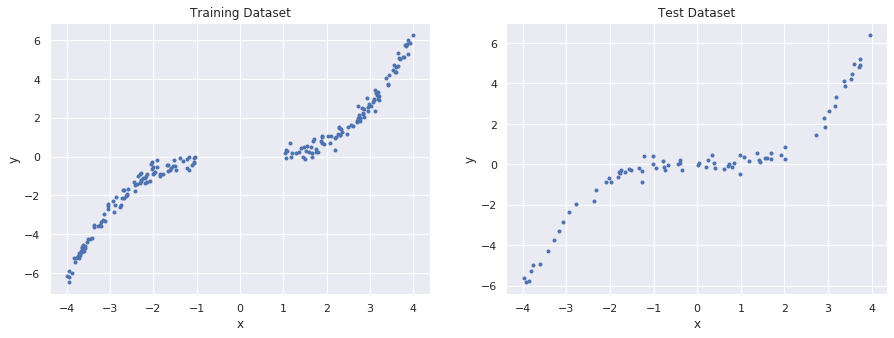

In [8]:
# your code here
fig, ax =plt.subplots(1,2, figsize=(15,5))
ax[0].plot(train[0], train[1], '.', label='train')
ax[0].set_title('Training Dataset')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[1].plot(test[0], test[1],'.', label='test')
ax[1].set_xlabel('x')
ax[1].set_ylabel('y')
ax[1].set_title('Test Dataset');

**1.2** [2 pts] Create a fully connected neural network with 3 layers of 20 nodes each. Include dropout (using the Dropout class provided) before the last layer.


In [9]:
# https://github.com/keras-team/keras/issues/9412

class Dropout(layers.Dropout):
    """Applies Dropout to the input.
    Dropout consists in randomly setting
    a fraction `rate` of input units to 0 at each update during training time,
    which helps prevent overfitting.
    # Arguments
        rate: float between 0 and 1. Fraction of the input units to drop.
        noise_shape: 1D integer tensor representing the shape of the
            binary dropout mask that will be multiplied with the input.
            For instance, if your inputs have shape
            `(batch_size, timesteps, features)` and
            you want the dropout mask to be the same for all timesteps,
            you can use `noise_shape=(batch_size, 1, features)`.
        seed: A Python integer to use as random seed.
    # References
        - [Dropout: A Simple Way to Prevent Neural Networks from Overfitting](
           http://www.jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)
    """
    def __init__(self, rate, training=None, noise_shape=None, seed=None, **kwargs):
        super(Dropout, self).__init__(rate, noise_shape=None, seed=None,**kwargs)
        self.training = training

        
    def call(self, inputs, training=None):
        if 0. < self.rate < 1.:
            noise_shape = self._get_noise_shape(inputs)

            def dropped_inputs():
                return K.dropout(inputs, self.rate, noise_shape,
                                 seed=self.seed)
            if not training: 
                return K.in_train_phase(dropped_inputs, inputs, training=self.training)
            return K.in_train_phase(dropped_inputs, inputs, training=training)
        return inputs

In [10]:
# create model 
# your code here 
fcnn = Sequential()

fcnn.add(Dense(20, activation='relu', input_shape=(1,)))
fcnn.add(Dense(20, activation='relu'))
fcnn.add(Dense(20, activation='relu'))
fcnn.add(Dropout(0.1))
fcnn.add(Dense(1, activation='linear'))

fcnn.compile(optimizer='adam', loss='mse')
fcnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                40        
_________________________________________________________________
dense_1 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_2 (Dense)              (None, 20)                420       
_________________________________________________________________
dropout (Dropout)            (None, 20)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 21        
Total params: 901
Trainable params: 901
Non-trainable params: 0
_________________________________________________________________


In [11]:
# create validation dataset
x_train, x_val, y_train, y_val = train_test_split(train[0], train[1], test_size=0.1, shuffle=True)
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

(180,) (180,) (20,) (20,)


In [12]:
# Fit the model
# your code here
epochs = 20
batch_size=16

history_fcnn = fcnn.fit(x_train, y_train, 
                        epochs=epochs, batch_size=batch_size,
                        validation_data=(x_val, y_val))

Train on 180 samples, validate on 20 samples
Epoch 1/20
180/180 [==============================] - 1s 5ms/sample - loss: 8.5261 - val_loss: 9.8897
Epoch 2/20
180/180 [==============================] - 0s 230us/sample - loss: 7.0730 - val_loss: 8.3012
Epoch 3/20
180/180 [==============================] - 0s 247us/sample - loss: 5.9023 - val_loss: 6.8905
Epoch 4/20
180/180 [==============================] - 0s 244us/sample - loss: 4.6791 - val_loss: 5.4596
Epoch 5/20
180/180 [==============================] - 0s 231us/sample - loss: 3.7244 - val_loss: 4.1198
Epoch 6/20
180/180 [==============================] - 0s 234us/sample - loss: 2.8066 - val_loss: 3.2963
Epoch 7/20
180/180 [==============================] - 0s 236us/sample - loss: 2.2361 - val_loss: 2.8300
Epoch 8/20
180/180 [==============================] - 0s 228us/sample - loss: 1.8750 - val_loss: 2.4770
Epoch 9/20
180/180 [==============================] - 0s 248us/sample - loss: 1.7669 - val_loss: 2.1297
Epoch 10/20
180/180 [

In [13]:
# evaluate the training and testing performance of your model 
# your code here
results = fcnn.evaluate(test[0], test[1], batch_size=32)
print('test loss, test acc:', results)

from sklearn.metrics import mean_squared_error

mse_train = mean_squared_error(y_train, fcnn.predict(x_train))
mse_test = mean_squared_error(test[1], fcnn.predict(test[0]))
print('MSE for training dataset:', mse_train)
print('MSE for test dataset:', mse_test)

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

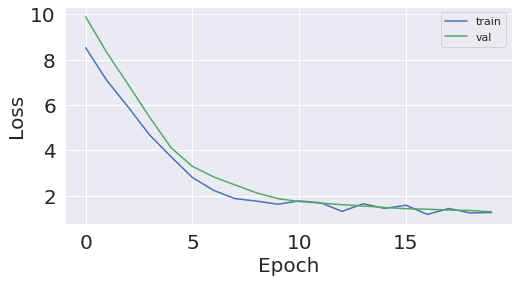

In [14]:
# plot 
# your code here 
def print_history(history):
#     fig, ax = plt.subplots(1, 1, figsize=(8,4))
#     ax.plot((history.history['mse']), 'b', label='train')
#     ax.plot((history.history['val_mse']), 'g' ,label='val')
#     ax.set_xlabel(r'Epoch', fontsize=20)
#     ax.set_ylabel(r'mse', fontsize=20)
#     ax.legend()
#     ax.tick_params(labelsize=20)
    fig, ax = plt.subplots(1, 1, figsize=(8,4))
    ax.plot((history.history['loss']), 'b', label='train')
    ax.plot((history.history['val_loss']), 'g' ,label='val')
    ax.set_xlabel(r'Epoch', fontsize=20)
    ax.set_ylabel(r'Loss', fontsize=20)
    ax.legend()
    ax.tick_params(labelsize=20)
    plt.show();
    
print_history(history_fcnn)

**1.3** [2 pts] Train the network with dropout of 0.1, do inference for all the test points 10 times in training mode. From the outputs, find the model mean and standard variation. Repeat with dropoout of 0.2.


In [20]:
# your code here
# predict 10 times and get the std and mean
pred = []
for i in range(10):
    y_pred = fcnn.predict(test[0][test_idx])
    pred.append(y_pred.flatten())

pred= np.stack(pred, axis=0)
print('mean:', pred.mean(axis=0))
print('std:', pred.std(axis=0))

mean: [-4.2796144  -4.2257924  -4.1324234  -4.055115   -3.9935946  -3.8018699
 -3.5714545  -3.3779678  -3.2207522  -3.1056938  -2.943775   -2.7249334
 -2.1788106  -2.128673   -1.8378737  -1.727009   -1.6726868  -1.4855839
 -1.4526433  -1.4085499  -1.3708212  -1.2659539  -1.1446725  -1.0832502
 -0.84693706 -0.763544   -0.7542495  -0.6945348  -0.448111   -0.44448847
 -0.34498253 -0.15249613 -0.11103648 -0.10343798 -0.02279677  0.16381077
  0.17722155  0.18784632  0.20297202  0.32924896  0.34447452  0.4442206
  0.47592306  0.55344754  0.5725788   0.60356104  0.75307417  0.8222488
  0.8430619   0.8917249   0.9139377   1.0225383   1.0234631   1.0939139
  1.177848    1.3353033   1.3625544   1.3897208   1.483553    1.5109298
  1.5797445   1.5809715   1.7703526   1.837586    1.8386738   2.4050043
  2.5531309   2.5849235   2.6613252   2.764626    2.7734225   2.9355605
  2.9486556   3.0513153   3.0664983   3.1066482   3.1956103   3.2277465
  3.2288394   3.3962936 ]
std: [4.7683716e-07 0.0000000e

In [16]:
# your code here
fcnn2 = Sequential()

fcnn2.add(Dense(20, activation='relu', input_shape=(1,)))
fcnn2.add(Dense(20, activation='relu'))
fcnn2.add(Dense(20, activation='relu'))
fcnn2.add(Dropout(0.2))
fcnn2.add(Dense(1, activation='linear'))

fcnn2.compile(optimizer='adam', loss='mse')
fcnn2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 20)                40        
_________________________________________________________________
dense_5 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_6 (Dense)              (None, 20)                420       
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 21        
Total params: 901
Trainable params: 901
Non-trainable params: 0
_________________________________________________________________


In [17]:
history_fcnn2 = fcnn2.fit(x_train, y_train, 
                        epochs=epochs, batch_size=batch_size,
                        validation_data=(x_val, y_val))

Train on 180 samples, validate on 20 samples
Epoch 1/20
180/180 [==============================] - 1s 4ms/sample - loss: 6.7981 - val_loss: 8.0847
Epoch 2/20
180/180 [==============================] - 0s 257us/sample - loss: 6.0465 - val_loss: 7.1878
Epoch 3/20
180/180 [==============================] - 0s 254us/sample - loss: 5.1732 - val_loss: 6.2661
Epoch 4/20
180/180 [==============================] - 0s 252us/sample - loss: 4.6363 - val_loss: 5.3604
Epoch 5/20
180/180 [==============================] - 0s 261us/sample - loss: 3.8989 - val_loss: 4.4645
Epoch 6/20
180/180 [==============================] - 0s 254us/sample - loss: 3.0151 - val_loss: 3.5893
Epoch 7/20
180/180 [==============================] - 0s 256us/sample - loss: 2.9298 - val_loss: 2.8557
Epoch 8/20
180/180 [==============================] - 0s 258us/sample - loss: 2.2585 - val_loss: 2.2809
Epoch 9/20
180/180 [==============================] - 0s 262us/sample - loss: 2.0310 - val_loss: 1.9557
Epoch 10/20
180/180 [

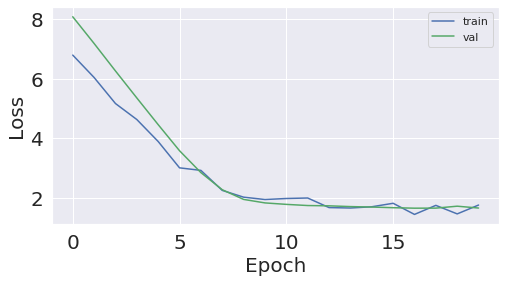

In [18]:
print_history(history_fcnn2)

In [21]:
pred2 = []
for i in range(10):
    y_pred = fcnn2.predict(test[0][test_idx])
    pred2.append(y_pred.flatten())
    
pred2=np.stack(pred2, axis=0)
print(pred2.mean(axis=0).shape)
print('mean:', pred2.mean(axis=0))
print('std:', pred2.std(axis=0))

(80,)
mean: [-3.6871715  -3.6521747  -3.5914638  -3.5411963  -3.5011926  -3.3765297
 -3.2267075  -3.100897   -2.998672   -2.9238582  -2.8185737  -2.6762774
 -2.3211746  -2.2885735  -2.0994887  -2.0274012  -1.992079   -1.8704202
 -1.8490012  -1.8203304  -1.7957985  -1.7276108  -1.6487505  -1.6088126
 -1.452592   -1.3972645  -1.3910979  -1.3514801  -1.1879884  -1.185585
 -1.119567   -0.991861   -0.9632956  -0.9579522  -0.88531554 -0.691791
 -0.6704712  -0.6533809  -0.6289111  -0.3180869  -0.29465768 -0.19185641
 -0.14622329 -0.0382083  -0.01462772  0.02314228  0.21814325  0.3050838
  0.33171555  0.3945448   0.42322403  0.56128865  0.5624592   0.6521887
  0.7549389   0.94769204  0.9810524   1.0143088   1.1296808   1.1634823
  1.2479792   1.2494832   1.4816482   1.5640705   1.565404    2.2596745
  2.437198    2.4753091   2.5668929   2.690722    2.7012665   2.893957
  2.9094353   3.0292187   3.0465608   3.09242     3.1940324   3.2307363
  3.2319856   3.4251046 ]
std: [2.3841858e-07 0.000000

**1.4** [1 pt] Make a plot of the data, the model, and the uncertainty. Show the model mean and color the region of tow standard deviations.


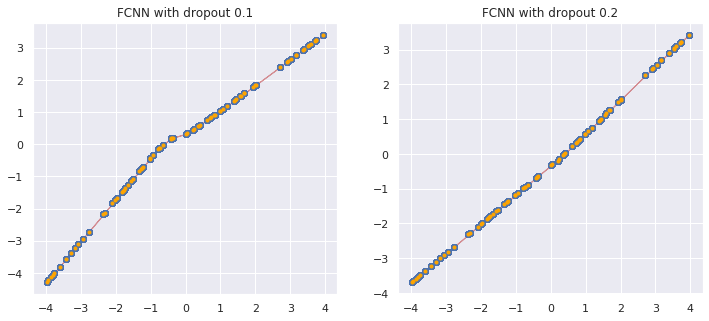

In [22]:
# plot 
# your code here
f,ax = plt.subplots(1,2, figsize=(12,5))

for i in range(10):
    ax[0].plot(test[0][test_idx], pred[i], 'o', color='b')
ax[0].fill_between(test[0][test_idx], 
                 pred.mean(axis=0)+2*pred2.std(axis=0), 
                 pred.mean(axis=0)-2*pred2.std(axis=0),
                 color='r', alpha=0.6)
ax[0].plot(test[0][test_idx], pred.mean(axis=0), '.', color='orange')
# plt.plot(test[0], pred2.mean(axis=0), '-', color='r')
ax[0].set_title('FCNN with dropout 0.1')

for i in range(10):
    ax[1].plot(test[0][test_idx], pred2[i], 'o', color='b')
ax[1].fill_between(test[0][test_idx], 
                 pred2.mean(axis=0)+2*pred2.std(axis=0), 
                 pred2.mean(axis=0)-2*pred2.std(axis=0),
                 color='r', alpha=0.6)
ax[1].plot(test[0][test_idx], pred2.mean(axis=0), '.', color='orange')
# plt.plot(test[0], pred2.mean(axis=0), '-', color='r')
ax[1].set_title('FCNN with dropout 0.2');

**1.5** [2 pts] Turn dropout off (set it to 0) and train 50 models bootstrapping the training data. Doing statistics on the outputs, make a plot of the data, the model, and the uncertainty. Show the model mean and color the region tow standard deviations away, as in **1.3**


In [23]:
# define model 
# your code here 
fcnn3 = Sequential()

fcnn3.add(Dense(20, activation='relu', input_shape=(1,)))
fcnn3.add(Dense(20, activation='relu'))
fcnn3.add(Dense(20, activation='relu'))
fcnn3.add(Dropout(0))
fcnn3.add(Dense(1, activation='linear'))

fcnn3.compile(optimizer='adam', loss='mse')
fcnn3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 20)                40        
_________________________________________________________________
dense_9 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_10 (Dense)             (None, 20)                420       
_________________________________________________________________
dropout_2 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 21        
Total params: 901
Trainable params: 901
Non-trainable params: 0
_________________________________________________________________


In [24]:
# you may need this 
# from https://github.com/keras-team/keras/issues/341#issuecomment-438347068

def reset_weights(model):
    for layer in model.layers: 
        if isinstance(layer, tf.keras.Model):
            reset_weights(layer)
            continue
    for k, initializer in layer.__dict__.items():
        if "initializer" not in k:
            continue
        # find the corresponding variable
        var = getattr(layer, k.replace("_initializer", ""))
        var.assign(initializer(var.shape, var.dtype))

In [25]:
# Bootstrap and run model 
# your code here 
sort_idx=np.argsort(test[0])
x_test_ = test[0][sort_idx]
y_test = test[1][sort_idx]

epochs=20
X, y = train[0], train[1]
models=[]
preds=[]
count=0

kf = KFold(n_splits=50)

for train_index, test_index in kf.split(X):
    print(len(train_index))
    x_train, x_discard = X[train_index], X[test_index]
    y_train, y_discard = y[train_index], y[test_index]
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, shuffle=True)
#     count+=1
#     print(count)
    
    fcnn3.fit(x_train, y_train, 
              epochs=epochs, batch_size=batch_size,
             validation_data=(x_val, y_val))
    
    y_pred = fcnn3.predict(test[0][sort_idx])
    preds.append(y_pred.flatten())
    
    models.append(fcnn3)
    
    reset_weights(fcnn3)
    
#     print(f'finish training {count} times')
#     count+=1

196
Train on 176 samples, validate on 20 samples
Epoch 1/20
176/176 [==============================] - 0s 3ms/sample - loss: 7.9856 - val_loss: 8.5686
Epoch 2/20
176/176 [==============================] - 0s 195us/sample - loss: 7.4022 - val_loss: 7.9440
Epoch 3/20
176/176 [==============================] - 0s 194us/sample - loss: 6.8408 - val_loss: 7.2659
Epoch 4/20
176/176 [==============================] - 0s 197us/sample - loss: 6.1341 - val_loss: 6.4477
Epoch 5/20
176/176 [==============================] - 0s 201us/sample - loss: 5.3043 - val_loss: 5.4624
Epoch 6/20
176/176 [==============================] - 0s 202us/sample - loss: 4.3937 - val_loss: 4.3582
Epoch 7/20
176/176 [==============================] - 0s 204us/sample - loss: 3.4001 - val_loss: 3.3080
Epoch 8/20
176/176 [==============================] - 0s 201us/sample - loss: 2.5741 - val_loss: 2.4035
Epoch 9/20
176/176 [==============================] - 0s 196us/sample - loss: 1.9712 - val_loss: 1.7794
Epoch 10/20
176/1

176/176 [==============================] - 0s 196us/sample - loss: 0.5617 - val_loss: 0.4689
Epoch 18/20
176/176 [==============================] - 0s 193us/sample - loss: 0.5345 - val_loss: 0.4560
Epoch 19/20
176/176 [==============================] - 0s 194us/sample - loss: 0.5180 - val_loss: 0.4258
Epoch 20/20
176/176 [==============================] - 0s 199us/sample - loss: 0.4977 - val_loss: 0.4325
196
Train on 176 samples, validate on 20 samples
Epoch 1/20
176/176 [==============================] - 0s 239us/sample - loss: 0.7503 - val_loss: 0.6736
Epoch 2/20
176/176 [==============================] - 0s 202us/sample - loss: 0.5823 - val_loss: 0.5192
Epoch 3/20
176/176 [==============================] - 0s 194us/sample - loss: 0.5474 - val_loss: 0.4768
Epoch 4/20
176/176 [==============================] - 0s 193us/sample - loss: 0.4904 - val_loss: 0.5574
Epoch 5/20
176/176 [==============================] - 0s 196us/sample - loss: 0.4720 - val_loss: 0.4772
Epoch 6/20
176/176 [===

176/176 [==============================] - 0s 271us/sample - loss: 0.2452 - val_loss: 0.1350
Epoch 14/20
176/176 [==============================] - 0s 261us/sample - loss: 0.2338 - val_loss: 0.1194
Epoch 15/20
176/176 [==============================] - 0s 227us/sample - loss: 0.2309 - val_loss: 0.1165
Epoch 16/20
176/176 [==============================] - 0s 230us/sample - loss: 0.2174 - val_loss: 0.1118
Epoch 17/20
176/176 [==============================] - 0s 256us/sample - loss: 0.2102 - val_loss: 0.1171
Epoch 18/20
176/176 [==============================] - 0s 229us/sample - loss: 0.2026 - val_loss: 0.1037
Epoch 19/20
176/176 [==============================] - 0s 243us/sample - loss: 0.1961 - val_loss: 0.0992
Epoch 20/20
176/176 [==============================] - 0s 232us/sample - loss: 0.1900 - val_loss: 0.0944
196
Train on 176 samples, validate on 20 samples
Epoch 1/20
176/176 [==============================] - 0s 265us/sample - loss: 1.6487 - val_loss: 1.9546
Epoch 2/20
176/176 

176/176 [==============================] - 0s 229us/sample - loss: 0.3065 - val_loss: 0.4309
Epoch 10/20
176/176 [==============================] - 0s 217us/sample - loss: 0.2907 - val_loss: 0.3989
Epoch 11/20
176/176 [==============================] - 0s 221us/sample - loss: 0.2771 - val_loss: 0.3837
Epoch 12/20
176/176 [==============================] - 0s 229us/sample - loss: 0.2637 - val_loss: 0.3768
Epoch 13/20
176/176 [==============================] - 0s 232us/sample - loss: 0.2476 - val_loss: 0.3545
Epoch 14/20
176/176 [==============================] - 0s 217us/sample - loss: 0.2412 - val_loss: 0.3468
Epoch 15/20
176/176 [==============================] - 0s 220us/sample - loss: 0.2314 - val_loss: 0.3234
Epoch 16/20
176/176 [==============================] - 0s 218us/sample - loss: 0.2162 - val_loss: 0.3150
Epoch 17/20
176/176 [==============================] - 0s 232us/sample - loss: 0.2023 - val_loss: 0.3001
Epoch 18/20
176/176 [==============================] - 0s 216us/sam

176/176 [==============================] - 0s 201us/sample - loss: 4.4439 - val_loss: 3.0057
Epoch 6/20
176/176 [==============================] - 0s 194us/sample - loss: 3.8051 - val_loss: 2.5667
Epoch 7/20
176/176 [==============================] - 0s 190us/sample - loss: 3.3571 - val_loss: 2.1659
Epoch 8/20
176/176 [==============================] - 0s 196us/sample - loss: 2.9365 - val_loss: 1.8235
Epoch 9/20
176/176 [==============================] - 0s 192us/sample - loss: 2.5505 - val_loss: 1.5557
Epoch 10/20
176/176 [==============================] - 0s 201us/sample - loss: 2.2449 - val_loss: 1.3006
Epoch 11/20
176/176 [==============================] - 0s 193us/sample - loss: 1.9544 - val_loss: 1.0962
Epoch 12/20
176/176 [==============================] - 0s 198us/sample - loss: 1.6966 - val_loss: 0.9234
Epoch 13/20
176/176 [==============================] - 0s 198us/sample - loss: 1.4531 - val_loss: 0.7932
Epoch 14/20
176/176 [==============================] - 0s 198us/sample 

176/176 [==============================] - 0s 223us/sample - loss: 13.2276 - val_loss: 7.6257
Epoch 2/20
176/176 [==============================] - 0s 197us/sample - loss: 10.1953 - val_loss: 5.4750
Epoch 3/20
176/176 [==============================] - 0s 202us/sample - loss: 7.0583 - val_loss: 3.3459
Epoch 4/20
176/176 [==============================] - 0s 195us/sample - loss: 3.6827 - val_loss: 1.2271
Epoch 5/20
176/176 [==============================] - 0s 197us/sample - loss: 1.1994 - val_loss: 0.3993
Epoch 6/20
176/176 [==============================] - 0s 191us/sample - loss: 0.5622 - val_loss: 0.3793
Epoch 7/20
176/176 [==============================] - 0s 200us/sample - loss: 0.5121 - val_loss: 0.3827
Epoch 8/20
176/176 [==============================] - 0s 194us/sample - loss: 0.4499 - val_loss: 0.3516
Epoch 9/20
176/176 [==============================] - 0s 205us/sample - loss: 0.4203 - val_loss: 0.3361
Epoch 10/20
176/176 [==============================] - 0s 203us/sample - 

Epoch 18/20
176/176 [==============================] - 0s 202us/sample - loss: 0.4295 - val_loss: 0.5046
Epoch 19/20
176/176 [==============================] - 0s 204us/sample - loss: 0.4220 - val_loss: 0.4921
Epoch 20/20
176/176 [==============================] - 0s 201us/sample - loss: 0.4157 - val_loss: 0.4896
196
Train on 176 samples, validate on 20 samples
Epoch 1/20
176/176 [==============================] - 0s 228us/sample - loss: 0.7114 - val_loss: 0.6880
Epoch 2/20
176/176 [==============================] - 0s 196us/sample - loss: 0.5162 - val_loss: 0.3828
Epoch 3/20
176/176 [==============================] - 0s 205us/sample - loss: 0.4380 - val_loss: 0.2900
Epoch 4/20
176/176 [==============================] - 0s 194us/sample - loss: 0.4195 - val_loss: 0.2951
Epoch 5/20
176/176 [==============================] - 0s 198us/sample - loss: 0.4002 - val_loss: 0.2943
Epoch 6/20
176/176 [==============================] - 0s 196us/sample - loss: 0.3845 - val_loss: 0.3109
Epoch 7/20
1

176/176 [==============================] - 0s 263us/sample - loss: 1.5033 - val_loss: 0.7348
Epoch 15/20
176/176 [==============================] - 0s 248us/sample - loss: 1.2946 - val_loss: 0.6764
Epoch 16/20
176/176 [==============================] - 0s 239us/sample - loss: 1.1389 - val_loss: 0.6448
Epoch 17/20
176/176 [==============================] - 0s 269us/sample - loss: 1.0329 - val_loss: 0.6287
Epoch 18/20
176/176 [==============================] - 0s 232us/sample - loss: 0.9299 - val_loss: 0.6314
Epoch 19/20
176/176 [==============================] - 0s 213us/sample - loss: 0.8808 - val_loss: 0.6452
Epoch 20/20
176/176 [==============================] - 0s 218us/sample - loss: 0.8249 - val_loss: 0.6550
196
Train on 176 samples, validate on 20 samples
Epoch 1/20
176/176 [==============================] - 0s 254us/sample - loss: 4.5111 - val_loss: 1.6953
Epoch 2/20
176/176 [==============================] - 0s 220us/sample - loss: 3.1057 - val_loss: 0.9258
Epoch 3/20
176/176 [

176/176 [==============================] - 0s 221us/sample - loss: 1.5225 - val_loss: 1.0182
Epoch 11/20
176/176 [==============================] - 0s 220us/sample - loss: 1.1597 - val_loss: 0.7216
Epoch 12/20
176/176 [==============================] - 0s 232us/sample - loss: 0.9204 - val_loss: 0.4889
Epoch 13/20
176/176 [==============================] - 0s 220us/sample - loss: 0.7100 - val_loss: 0.3583
Epoch 14/20
176/176 [==============================] - 0s 226us/sample - loss: 0.5860 - val_loss: 0.2895
Epoch 15/20
176/176 [==============================] - 0s 219us/sample - loss: 0.5066 - val_loss: 0.2648
Epoch 16/20
176/176 [==============================] - 0s 223us/sample - loss: 0.4552 - val_loss: 0.2596
Epoch 17/20
176/176 [==============================] - 0s 221us/sample - loss: 0.4257 - val_loss: 0.2585
Epoch 18/20
176/176 [==============================] - 0s 227us/sample - loss: 0.4111 - val_loss: 0.2622
Epoch 19/20
176/176 [==============================] - 0s 212us/sam

176/176 [==============================] - 0s 195us/sample - loss: 1.3949 - val_loss: 0.8206
Epoch 7/20
176/176 [==============================] - 0s 205us/sample - loss: 1.0475 - val_loss: 0.6152
Epoch 8/20
176/176 [==============================] - 0s 198us/sample - loss: 0.8179 - val_loss: 0.4894
Epoch 9/20
176/176 [==============================] - 0s 197us/sample - loss: 0.6559 - val_loss: 0.4290
Epoch 10/20
176/176 [==============================] - 0s 193us/sample - loss: 0.5650 - val_loss: 0.4030
Epoch 11/20
176/176 [==============================] - 0s 196us/sample - loss: 0.5185 - val_loss: 0.3971
Epoch 12/20
176/176 [==============================] - 0s 199us/sample - loss: 0.4927 - val_loss: 0.3995
Epoch 13/20
176/176 [==============================] - 0s 204us/sample - loss: 0.4724 - val_loss: 0.3950
Epoch 14/20
176/176 [==============================] - 0s 195us/sample - loss: 0.4632 - val_loss: 0.3921
Epoch 15/20
176/176 [==============================] - 0s 199us/sample

176/176 [==============================] - 0s 197us/sample - loss: 5.8269 - val_loss: 7.4469
Epoch 3/20
176/176 [==============================] - 0s 195us/sample - loss: 5.4206 - val_loss: 7.1317
Epoch 4/20
176/176 [==============================] - 0s 199us/sample - loss: 5.2343 - val_loss: 6.9433
Epoch 5/20
176/176 [==============================] - 0s 193us/sample - loss: 5.1093 - val_loss: 6.7945
Epoch 6/20
176/176 [==============================] - 0s 194us/sample - loss: 4.9922 - val_loss: 6.6617
Epoch 7/20
176/176 [==============================] - 0s 196us/sample - loss: 4.8851 - val_loss: 6.5348
Epoch 8/20
176/176 [==============================] - 0s 200us/sample - loss: 4.7752 - val_loss: 6.4189
Epoch 9/20
176/176 [==============================] - 0s 191us/sample - loss: 4.6778 - val_loss: 6.3071
Epoch 10/20
176/176 [==============================] - 0s 191us/sample - loss: 4.5894 - val_loss: 6.2179
Epoch 11/20
176/176 [==============================] - 0s 199us/sample - l

176/176 [==============================] - 0s 195us/sample - loss: 1.9187 - val_loss: 1.5094
Epoch 20/20
176/176 [==============================] - 0s 197us/sample - loss: 1.9137 - val_loss: 1.5014
196
Train on 176 samples, validate on 20 samples
Epoch 1/20
176/176 [==============================] - 0s 221us/sample - loss: 35.9992 - val_loss: 20.4933
Epoch 2/20
176/176 [==============================] - 0s 201us/sample - loss: 20.6282 - val_loss: 14.3862
Epoch 3/20
176/176 [==============================] - 0s 203us/sample - loss: 13.9244 - val_loss: 12.0292
Epoch 4/20
176/176 [==============================] - 0s 195us/sample - loss: 11.5218 - val_loss: 11.0658
Epoch 5/20
176/176 [==============================] - 0s 200us/sample - loss: 10.4754 - val_loss: 10.3917
Epoch 6/20
176/176 [==============================] - 0s 192us/sample - loss: 9.7476 - val_loss: 9.9316
Epoch 7/20
176/176 [==============================] - 0s 196us/sample - loss: 9.2875 - val_loss: 9.6226
Epoch 8/20
176/

176/176 [==============================] - 0s 194us/sample - loss: 2.0792 - val_loss: 1.9827
Epoch 16/20
176/176 [==============================] - 0s 200us/sample - loss: 2.0262 - val_loss: 1.9261
Epoch 17/20
176/176 [==============================] - 0s 195us/sample - loss: 1.9745 - val_loss: 1.8859
Epoch 18/20
176/176 [==============================] - 0s 198us/sample - loss: 1.9344 - val_loss: 1.8510
Epoch 19/20
176/176 [==============================] - 0s 196us/sample - loss: 1.9012 - val_loss: 1.8163
Epoch 20/20
176/176 [==============================] - 0s 197us/sample - loss: 1.8622 - val_loss: 1.7802
196
Train on 176 samples, validate on 20 samples
Epoch 1/20
176/176 [==============================] - 0s 225us/sample - loss: 5.7009 - val_loss: 6.4394
Epoch 2/20
176/176 [==============================] - 0s 202us/sample - loss: 5.0449 - val_loss: 5.4534
Epoch 3/20
176/176 [==============================] - 0s 194us/sample - loss: 4.2382 - val_loss: 4.4583
Epoch 4/20
176/176 [=

176/176 [==============================] - 0s 192us/sample - loss: 1.0216 - val_loss: 0.6889
Epoch 12/20
176/176 [==============================] - 0s 198us/sample - loss: 0.9929 - val_loss: 0.6715
Epoch 13/20
176/176 [==============================] - 0s 211us/sample - loss: 0.9648 - val_loss: 0.6428
Epoch 14/20
176/176 [==============================] - 0s 200us/sample - loss: 0.9374 - val_loss: 0.6311
Epoch 15/20
176/176 [==============================] - 0s 195us/sample - loss: 0.9067 - val_loss: 0.6032
Epoch 16/20
176/176 [==============================] - 0s 200us/sample - loss: 0.8736 - val_loss: 0.5741
Epoch 17/20
176/176 [==============================] - 0s 217us/sample - loss: 0.8401 - val_loss: 0.5440
Epoch 18/20
176/176 [==============================] - 0s 202us/sample - loss: 0.8053 - val_loss: 0.5152
Epoch 19/20
176/176 [==============================] - 0s 197us/sample - loss: 0.7703 - val_loss: 0.4841
Epoch 20/20
176/176 [==============================] - 0s 197us/sam

In [26]:
# preds = []
# for i in range(50):
#     y_pred = models[i].predict(test[0])
#     preds.append(y_pred.flatten())
    
preds=np.stack(preds, axis=0)
print(preds.mean(axis=0).shape)
print('mean:', preds.mean(axis=0))
print('std:', preds.std(axis=0))

(80,)
mean: [-3.6822314  -3.63553    -3.5517902  -3.4818172  -3.4243803  -3.2407312
 -3.0189264  -2.8329318  -2.6823     -2.572003   -2.4174037  -2.2119489
 -1.7109944  -1.6662819  -1.4181838  -1.3295143  -1.2869439  -1.1547186
 -1.133699   -1.1061114  -1.0832275  -1.0214432  -0.9561203  -0.9253102
 -0.82544374 -0.7986546  -0.7957902  -0.77798074 -0.7194168  -0.71881235
 -0.70235825 -0.6714708  -0.6650837  -0.663891   -0.64920497 -0.61993486
 -0.6180561  -0.6165848  -0.61459494 -0.58930725 -0.58585525 -0.5595282
 -0.5486502  -0.5189094  -0.5109832  -0.49814025 -0.41741356 -0.36706933
 -0.351149   -0.31299144 -0.29472673 -0.19530751 -0.19438085 -0.11911919
 -0.02815086  0.1688511   0.20803924  0.24816035  0.39165723  0.43581736
  0.55205494  0.55418867  0.89426774  1.0242358   1.0263709   2.2422967
  2.5903425   2.6660037   2.848077    3.09432     3.115346    3.5030024
  3.5343006   3.7795556   3.8158178   3.911594    4.122496    4.1986623
  4.2012386   4.592506  ]
std: [1.7415229  1.70

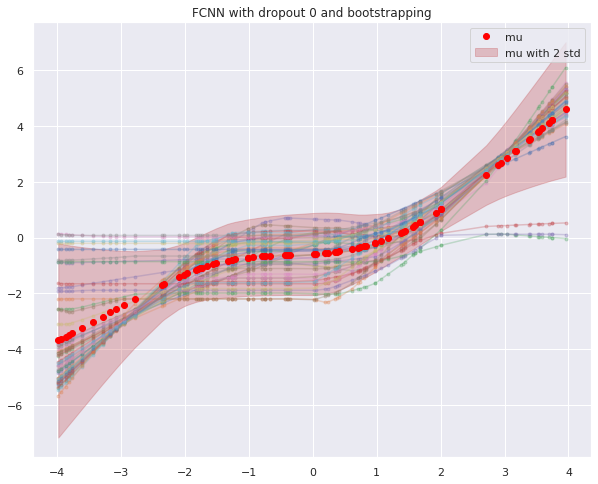

In [29]:
# plot 
# your code here 
y1 = preds.mean(axis=0)+2*preds.std(axis=0)
y2 = preds.mean(axis=0)-2*preds.std(axis=0)

plt.figure(figsize=(10,8))

for i in range(50):
    plt.plot(test[0][sort_idx], preds[i], '.-', alpha=0.3)
plt.fill_between(test[0][sort_idx], y1, y2, color='r', alpha=0.3, label='mu with 2 std')
# plt.plot(test[0], y1, '-', color='green')
plt.plot(test[0][sort_idx], preds.mean(axis=0), 'o', color='red', label='mu')
# plt.plot(test[0], pred2.mean(axis=0), '-', color='r')
plt.legend()
plt.title('FCNN with dropout 0 and bootstrapping');

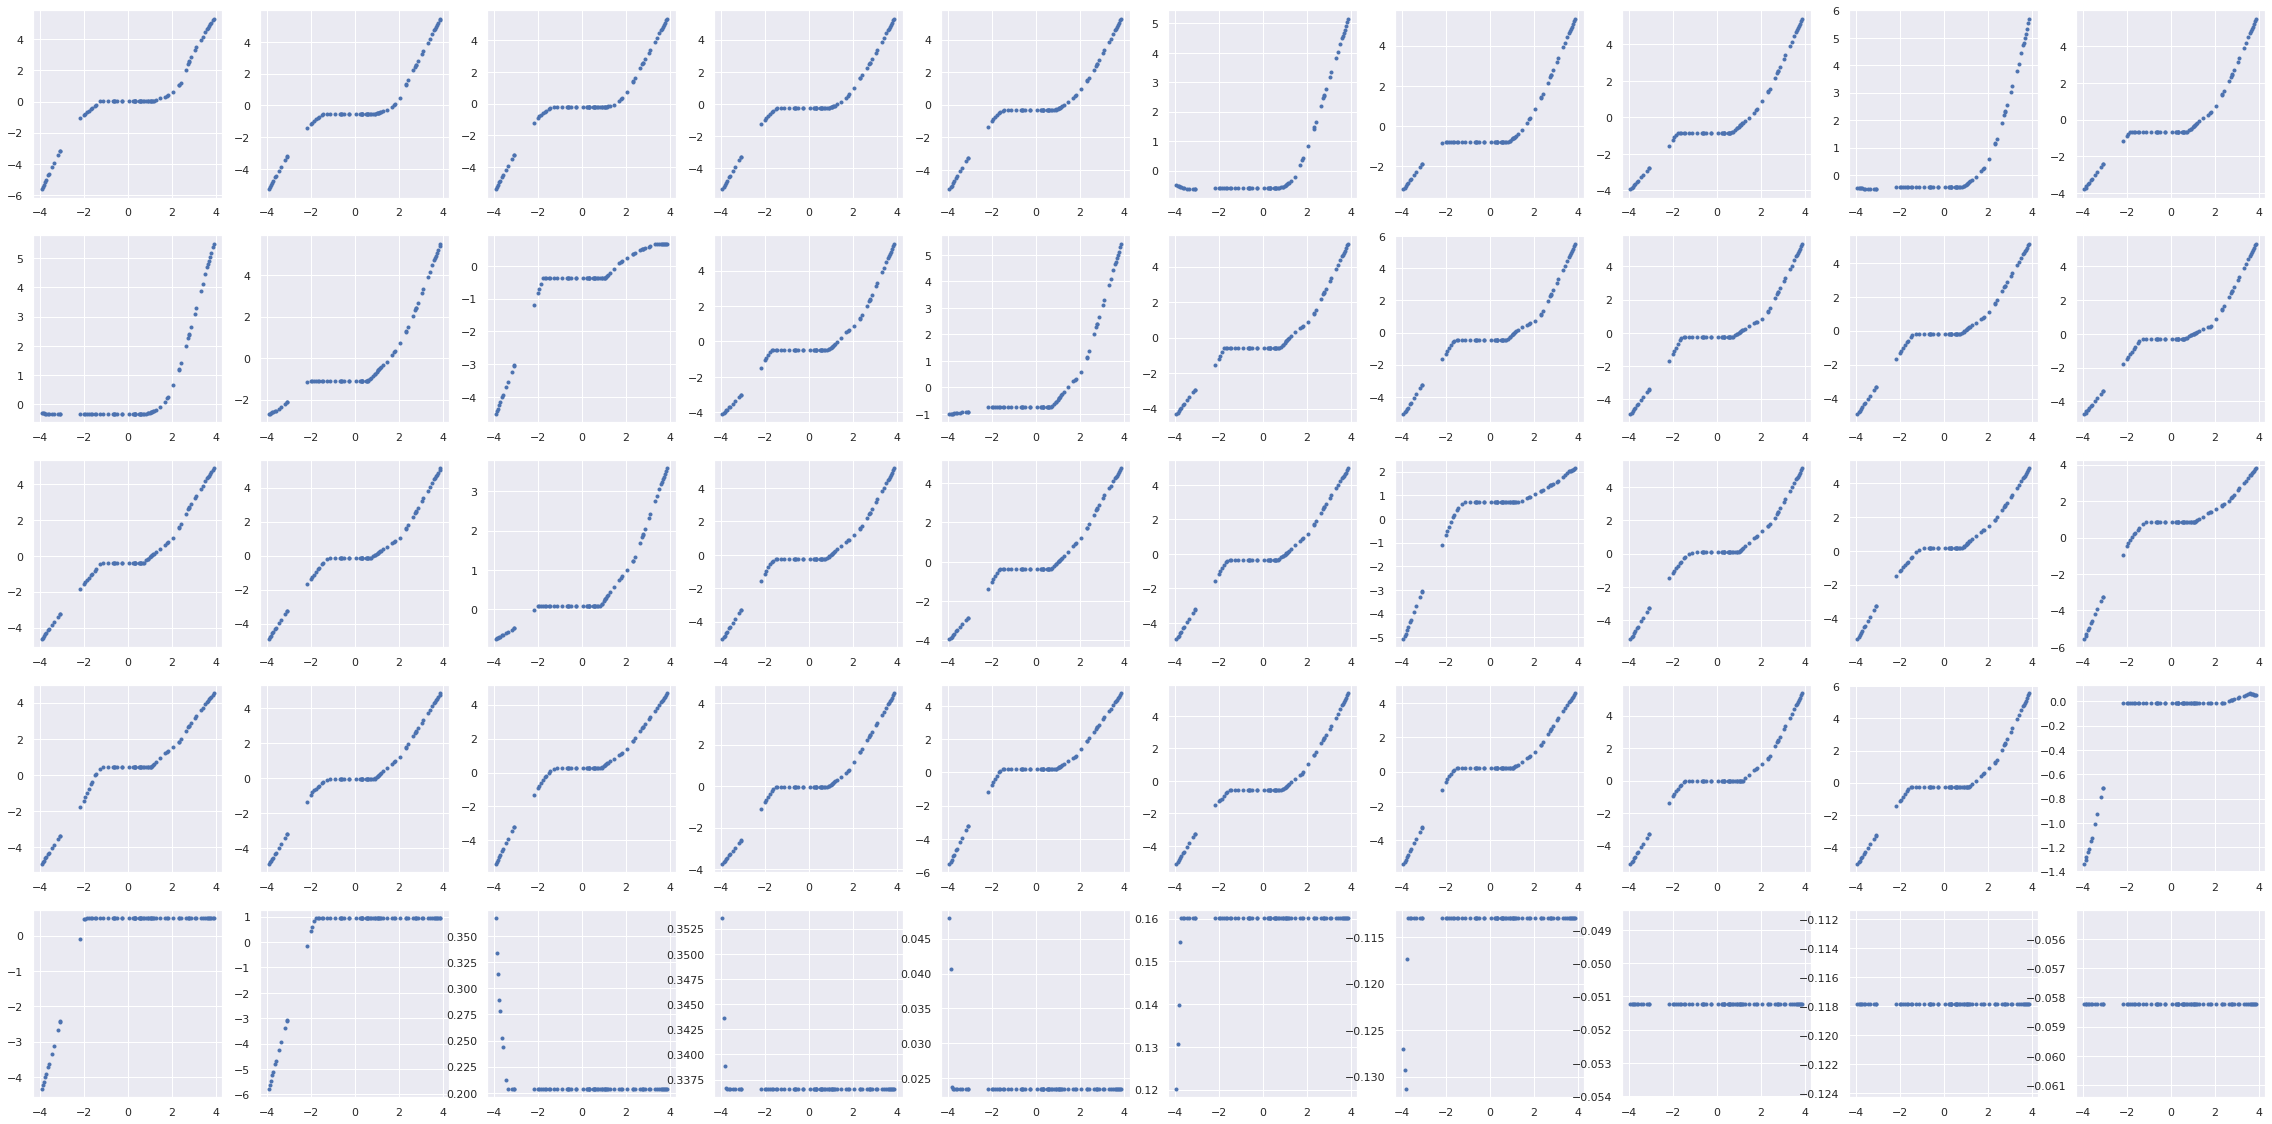

In [276]:
# plot 
# check whether different models predict different values
f, ax = plt.subplots(5,10, figsize=(40,20))
for i in range(50):
    row = i//10
    col = i%10
    ax[row,col].plot(test[0][sort_idx], preds[i], '.')

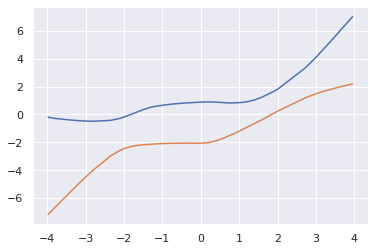

In [30]:
plt.plot(test[0][sort_idx],y1)
plt.plot(test[0][sort_idx],y2);

In [31]:
# TRY PREDICT 10 TIMES FOR EACH MODEL AND CHECK EACH MODEL'S PERFORMANCE

preds=[]  # prediction for all 50 models

for train_index, test_index in kf.split(X):
    print(len(train_index))
    x_train, x_discard = X[train_index], X[test_index]
    y_train, y_discard = y[train_index], y[test_index]
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, shuffle=True)
#     count+=1
#     print(count)
    
    fcnn3.fit(x_train, y_train, 
              epochs=epochs, batch_size=batch_size,
             validation_data=(x_val, y_val))
    
    
    
    # every model predict 10 times ##########################################
    m_pred=[]
    for i in range(10):
        y_pred = fcnn3.predict(test[0][sort_idx])
        m_pred.append(y_pred.flatten())
    preds.append(m_pred)
    
#     models.append(fcnn3)
    
    reset_weights(fcnn3)

196
Train on 176 samples, validate on 20 samples
Epoch 1/20
176/176 [==============================] - 0s 268us/sample - loss: 10.2962 - val_loss: 10.9031
Epoch 2/20
176/176 [==============================] - 0s 231us/sample - loss: 8.3325 - val_loss: 8.9669
Epoch 3/20
176/176 [==============================] - 0s 216us/sample - loss: 6.4932 - val_loss: 7.5993
Epoch 4/20
176/176 [==============================] - 0s 216us/sample - loss: 5.2419 - val_loss: 6.6247
Epoch 5/20
176/176 [==============================] - 0s 215us/sample - loss: 4.4661 - val_loss: 5.9411
Epoch 6/20
176/176 [==============================] - 0s 212us/sample - loss: 3.9403 - val_loss: 5.3962
Epoch 7/20
176/176 [==============================] - 0s 216us/sample - loss: 3.5093 - val_loss: 4.8137
Epoch 8/20
176/176 [==============================] - 0s 227us/sample - loss: 3.1118 - val_loss: 4.3092
Epoch 9/20
176/176 [==============================] - 0s 214us/sample - loss: 2.7844 - val_loss: 3.7974
Epoch 10/20
1

176/176 [==============================] - 0s 218us/sample - loss: 1.1133 - val_loss: 1.5001
Epoch 18/20
176/176 [==============================] - 0s 223us/sample - loss: 1.0435 - val_loss: 1.3766
Epoch 19/20
176/176 [==============================] - 0s 235us/sample - loss: 0.9806 - val_loss: 1.2495
Epoch 20/20
176/176 [==============================] - 0s 220us/sample - loss: 0.9403 - val_loss: 1.1629
196
Train on 176 samples, validate on 20 samples
Epoch 1/20
176/176 [==============================] - 0s 257us/sample - loss: 13.9693 - val_loss: 6.0812
Epoch 2/20
176/176 [==============================] - 0s 226us/sample - loss: 8.5800 - val_loss: 3.3822
Epoch 3/20
176/176 [==============================] - 0s 213us/sample - loss: 5.9067 - val_loss: 2.2846
Epoch 4/20
176/176 [==============================] - 0s 197us/sample - loss: 4.7038 - val_loss: 1.7941
Epoch 5/20
176/176 [==============================] - 0s 207us/sample - loss: 4.0693 - val_loss: 1.5055
Epoch 6/20
176/176 [==

176/176 [==============================] - 0s 217us/sample - loss: 1.4426 - val_loss: 0.1404
Epoch 14/20
176/176 [==============================] - 0s 221us/sample - loss: 1.2390 - val_loss: 0.1413
Epoch 15/20
176/176 [==============================] - 0s 219us/sample - loss: 1.0699 - val_loss: 0.1550
Epoch 16/20
176/176 [==============================] - 0s 233us/sample - loss: 0.9343 - val_loss: 0.1752
Epoch 17/20
176/176 [==============================] - 0s 222us/sample - loss: 0.8269 - val_loss: 0.1919
Epoch 18/20
176/176 [==============================] - 0s 219us/sample - loss: 0.7251 - val_loss: 0.2051
Epoch 19/20
176/176 [==============================] - 0s 215us/sample - loss: 0.6457 - val_loss: 0.2158
Epoch 20/20
176/176 [==============================] - 0s 218us/sample - loss: 0.5759 - val_loss: 0.2051
196
Train on 176 samples, validate on 20 samples
Epoch 1/20
176/176 [==============================] - 0s 263us/sample - loss: 3.6722 - val_loss: 2.2268
Epoch 2/20
176/176 

176/176 [==============================] - 0s 217us/sample - loss: 1.0884 - val_loss: 1.2045
Epoch 10/20
176/176 [==============================] - 0s 218us/sample - loss: 0.7352 - val_loss: 0.9240
Epoch 11/20
176/176 [==============================] - 0s 213us/sample - loss: 0.5861 - val_loss: 0.7740
Epoch 12/20
176/176 [==============================] - 0s 216us/sample - loss: 0.5113 - val_loss: 0.6962
Epoch 13/20
176/176 [==============================] - 0s 213us/sample - loss: 0.4758 - val_loss: 0.6419
Epoch 14/20
176/176 [==============================] - 0s 220us/sample - loss: 0.4478 - val_loss: 0.5921
Epoch 15/20
176/176 [==============================] - 0s 220us/sample - loss: 0.4169 - val_loss: 0.5600
Epoch 16/20
176/176 [==============================] - 0s 219us/sample - loss: 0.3935 - val_loss: 0.5341
Epoch 17/20
176/176 [==============================] - 0s 240us/sample - loss: 0.3730 - val_loss: 0.5044
Epoch 18/20
176/176 [==============================] - 0s 202us/sam

176/176 [==============================] - 0s 203us/sample - loss: 2.3667 - val_loss: 2.9677
Epoch 6/20
176/176 [==============================] - 0s 196us/sample - loss: 2.3173 - val_loss: 2.8968
Epoch 7/20
176/176 [==============================] - 0s 194us/sample - loss: 2.2631 - val_loss: 2.8377
Epoch 8/20
176/176 [==============================] - 0s 198us/sample - loss: 2.2262 - val_loss: 2.7706
Epoch 9/20
176/176 [==============================] - 0s 198us/sample - loss: 2.1873 - val_loss: 2.7039
Epoch 10/20
176/176 [==============================] - 0s 200us/sample - loss: 2.1550 - val_loss: 2.6475
Epoch 11/20
176/176 [==============================] - 0s 215us/sample - loss: 2.1185 - val_loss: 2.6031
Epoch 12/20
176/176 [==============================] - 0s 211us/sample - loss: 2.0942 - val_loss: 2.5515
Epoch 13/20
176/176 [==============================] - 0s 213us/sample - loss: 2.0651 - val_loss: 2.5161
Epoch 14/20
176/176 [==============================] - 0s 201us/sample 

176/176 [==============================] - 0s 298us/sample - loss: 4.0313 - val_loss: 1.1043
Epoch 2/20
176/176 [==============================] - 0s 231us/sample - loss: 2.7793 - val_loss: 1.3110
Epoch 3/20
176/176 [==============================] - 0s 234us/sample - loss: 2.4885 - val_loss: 0.9847
Epoch 4/20
176/176 [==============================] - 0s 221us/sample - loss: 2.2635 - val_loss: 0.9960
Epoch 5/20
176/176 [==============================] - 0s 232us/sample - loss: 2.1343 - val_loss: 1.0193
Epoch 6/20
176/176 [==============================] - 0s 248us/sample - loss: 2.0525 - val_loss: 1.0625
Epoch 7/20
176/176 [==============================] - 0s 243us/sample - loss: 2.0087 - val_loss: 1.0962
Epoch 8/20
176/176 [==============================] - 0s 250us/sample - loss: 1.9741 - val_loss: 1.1295
Epoch 9/20
176/176 [==============================] - 0s 218us/sample - loss: 1.9413 - val_loss: 1.1535
Epoch 10/20
176/176 [==============================] - 0s 244us/sample - lo

Epoch 18/20
176/176 [==============================] - 0s 195us/sample - loss: 3.3773 - val_loss: 2.6297
Epoch 19/20
176/176 [==============================] - 0s 194us/sample - loss: 3.1412 - val_loss: 2.3820
Epoch 20/20
176/176 [==============================] - 0s 195us/sample - loss: 2.9174 - val_loss: 2.1847
196
Train on 176 samples, validate on 20 samples
Epoch 1/20
176/176 [==============================] - 0s 267us/sample - loss: 8.7129 - val_loss: 8.3059
Epoch 2/20
176/176 [==============================] - 0s 221us/sample - loss: 8.0609 - val_loss: 7.6365
Epoch 3/20
176/176 [==============================] - 0s 220us/sample - loss: 7.3567 - val_loss: 7.0268
Epoch 4/20
176/176 [==============================] - 0s 216us/sample - loss: 6.7584 - val_loss: 6.4441
Epoch 5/20
176/176 [==============================] - 0s 223us/sample - loss: 6.2018 - val_loss: 5.9716
Epoch 6/20
176/176 [==============================] - 0s 220us/sample - loss: 5.7051 - val_loss: 5.5483
Epoch 7/20
1

176/176 [==============================] - 0s 199us/sample - loss: 2.9456 - val_loss: 4.4685
Epoch 15/20
176/176 [==============================] - 0s 195us/sample - loss: 2.8281 - val_loss: 4.2916
Epoch 16/20
176/176 [==============================] - 0s 192us/sample - loss: 2.7087 - val_loss: 4.1483
Epoch 17/20
176/176 [==============================] - 0s 201us/sample - loss: 2.6168 - val_loss: 4.0039
Epoch 18/20
176/176 [==============================] - 0s 197us/sample - loss: 2.5275 - val_loss: 3.8781
Epoch 19/20
176/176 [==============================] - 0s 195us/sample - loss: 2.4549 - val_loss: 3.7473
Epoch 20/20
176/176 [==============================] - 0s 196us/sample - loss: 2.3827 - val_loss: 3.6397
196
Train on 176 samples, validate on 20 samples
Epoch 1/20
176/176 [==============================] - 0s 225us/sample - loss: 3.4970 - val_loss: 5.6385
Epoch 2/20
176/176 [==============================] - 0s 201us/sample - loss: 3.3006 - val_loss: 5.3331
Epoch 3/20
176/176 [

176/176 [==============================] - 0s 206us/sample - loss: 3.0468 - val_loss: 4.9078
Epoch 11/20
176/176 [==============================] - 0s 197us/sample - loss: 2.9043 - val_loss: 4.7340
Epoch 12/20
176/176 [==============================] - 0s 195us/sample - loss: 2.7733 - val_loss: 4.5770
Epoch 13/20
176/176 [==============================] - 0s 196us/sample - loss: 2.6545 - val_loss: 4.4380
Epoch 14/20
176/176 [==============================] - 0s 199us/sample - loss: 2.5497 - val_loss: 4.3116
Epoch 15/20
176/176 [==============================] - 0s 195us/sample - loss: 2.4594 - val_loss: 4.1913
Epoch 16/20
176/176 [==============================] - 0s 203us/sample - loss: 2.3761 - val_loss: 4.0837
Epoch 17/20
176/176 [==============================] - 0s 197us/sample - loss: 2.3020 - val_loss: 3.9872
Epoch 18/20
176/176 [==============================] - 0s 201us/sample - loss: 2.2386 - val_loss: 3.9005
Epoch 19/20
176/176 [==============================] - 0s 202us/sam

176/176 [==============================] - 0s 218us/sample - loss: 5.2549 - val_loss: 5.2713
Epoch 7/20
176/176 [==============================] - 0s 225us/sample - loss: 4.9404 - val_loss: 4.9657
Epoch 8/20
176/176 [==============================] - 0s 225us/sample - loss: 4.6345 - val_loss: 4.6973
Epoch 9/20
176/176 [==============================] - 0s 222us/sample - loss: 4.3824 - val_loss: 4.4484
Epoch 10/20
176/176 [==============================] - 0s 227us/sample - loss: 4.1315 - val_loss: 4.2318
Epoch 11/20
176/176 [==============================] - 0s 223us/sample - loss: 3.9049 - val_loss: 4.0450
Epoch 12/20
176/176 [==============================] - 0s 222us/sample - loss: 3.7194 - val_loss: 3.8674
Epoch 13/20
176/176 [==============================] - 0s 221us/sample - loss: 3.5327 - val_loss: 3.7151
Epoch 14/20
176/176 [==============================] - 0s 224us/sample - loss: 3.3886 - val_loss: 3.5631
Epoch 15/20
176/176 [==============================] - 0s 218us/sample

176/176 [==============================] - 0s 215us/sample - loss: 12.4463 - val_loss: 10.9810
Epoch 3/20
176/176 [==============================] - 0s 213us/sample - loss: 6.8196 - val_loss: 6.6642
Epoch 4/20
176/176 [==============================] - 0s 216us/sample - loss: 5.0299 - val_loss: 5.2046
Epoch 5/20
176/176 [==============================] - 0s 219us/sample - loss: 4.3455 - val_loss: 4.5479
Epoch 6/20
176/176 [==============================] - 0s 221us/sample - loss: 3.9495 - val_loss: 4.0954
Epoch 7/20
176/176 [==============================] - 0s 225us/sample - loss: 3.6155 - val_loss: 3.7314
Epoch 8/20
176/176 [==============================] - 0s 218us/sample - loss: 3.3130 - val_loss: 3.4373
Epoch 9/20
176/176 [==============================] - 0s 229us/sample - loss: 3.0598 - val_loss: 3.1762
Epoch 10/20
176/176 [==============================] - 0s 226us/sample - loss: 2.8434 - val_loss: 2.9571
Epoch 11/20
176/176 [==============================] - 0s 214us/sample -

Epoch 19/20
176/176 [==============================] - 0s 218us/sample - loss: 1.9691 - val_loss: 2.8899
Epoch 20/20
176/176 [==============================] - 0s 221us/sample - loss: 1.9486 - val_loss: 2.8584
196
Train on 176 samples, validate on 20 samples
Epoch 1/20
176/176 [==============================] - 0s 262us/sample - loss: 5.0301 - val_loss: 5.0406
Epoch 2/20
176/176 [==============================] - 0s 216us/sample - loss: 4.2557 - val_loss: 4.1403
Epoch 3/20
176/176 [==============================] - 0s 217us/sample - loss: 3.8373 - val_loss: 3.7451
Epoch 4/20
176/176 [==============================] - 0s 225us/sample - loss: 3.4811 - val_loss: 3.4231
Epoch 5/20
176/176 [==============================] - 0s 219us/sample - loss: 3.1863 - val_loss: 3.2122
Epoch 6/20
176/176 [==============================] - 0s 192us/sample - loss: 2.9924 - val_loss: 3.0127
Epoch 7/20
176/176 [==============================] - 0s 198us/sample - loss: 2.8190 - val_loss: 2.8346
Epoch 8/20
17

176/176 [==============================] - 0s 223us/sample - loss: 2.0229 - val_loss: 3.1615
Epoch 16/20
176/176 [==============================] - 0s 221us/sample - loss: 1.9712 - val_loss: 3.0798
Epoch 17/20
176/176 [==============================] - 0s 221us/sample - loss: 1.9385 - val_loss: 3.0064
Epoch 18/20
176/176 [==============================] - 0s 230us/sample - loss: 1.8978 - val_loss: 2.9550
Epoch 19/20
176/176 [==============================] - 0s 232us/sample - loss: 1.8721 - val_loss: 2.9181
Epoch 20/20
176/176 [==============================] - 0s 216us/sample - loss: 1.8529 - val_loss: 2.8882
196
Train on 176 samples, validate on 20 samples
Epoch 1/20
176/176 [==============================] - 0s 279us/sample - loss: 5.9946 - val_loss: 1.7070
Epoch 2/20
176/176 [==============================] - 0s 224us/sample - loss: 3.7182 - val_loss: 0.9011
Epoch 3/20
176/176 [==============================] - 0s 223us/sample - loss: 3.3230 - val_loss: 0.9229
Epoch 4/20
176/176 [=

176/176 [==============================] - 0s 196us/sample - loss: 2.1183 - val_loss: 1.9975
Epoch 12/20
176/176 [==============================] - 0s 194us/sample - loss: 2.0734 - val_loss: 1.9895
Epoch 13/20
176/176 [==============================] - 0s 204us/sample - loss: 2.0491 - val_loss: 1.9766
Epoch 14/20
176/176 [==============================] - 0s 196us/sample - loss: 2.0198 - val_loss: 1.9810
Epoch 15/20
176/176 [==============================] - 0s 204us/sample - loss: 1.9998 - val_loss: 1.9717
Epoch 16/20
176/176 [==============================] - 0s 201us/sample - loss: 1.9837 - val_loss: 1.9601
Epoch 17/20
176/176 [==============================] - 0s 197us/sample - loss: 1.9703 - val_loss: 1.9605
Epoch 18/20
176/176 [==============================] - 0s 193us/sample - loss: 1.9649 - val_loss: 1.9672
Epoch 19/20
176/176 [==============================] - 0s 202us/sample - loss: 1.9524 - val_loss: 1.9530
Epoch 20/20
176/176 [==============================] - 0s 200us/sam

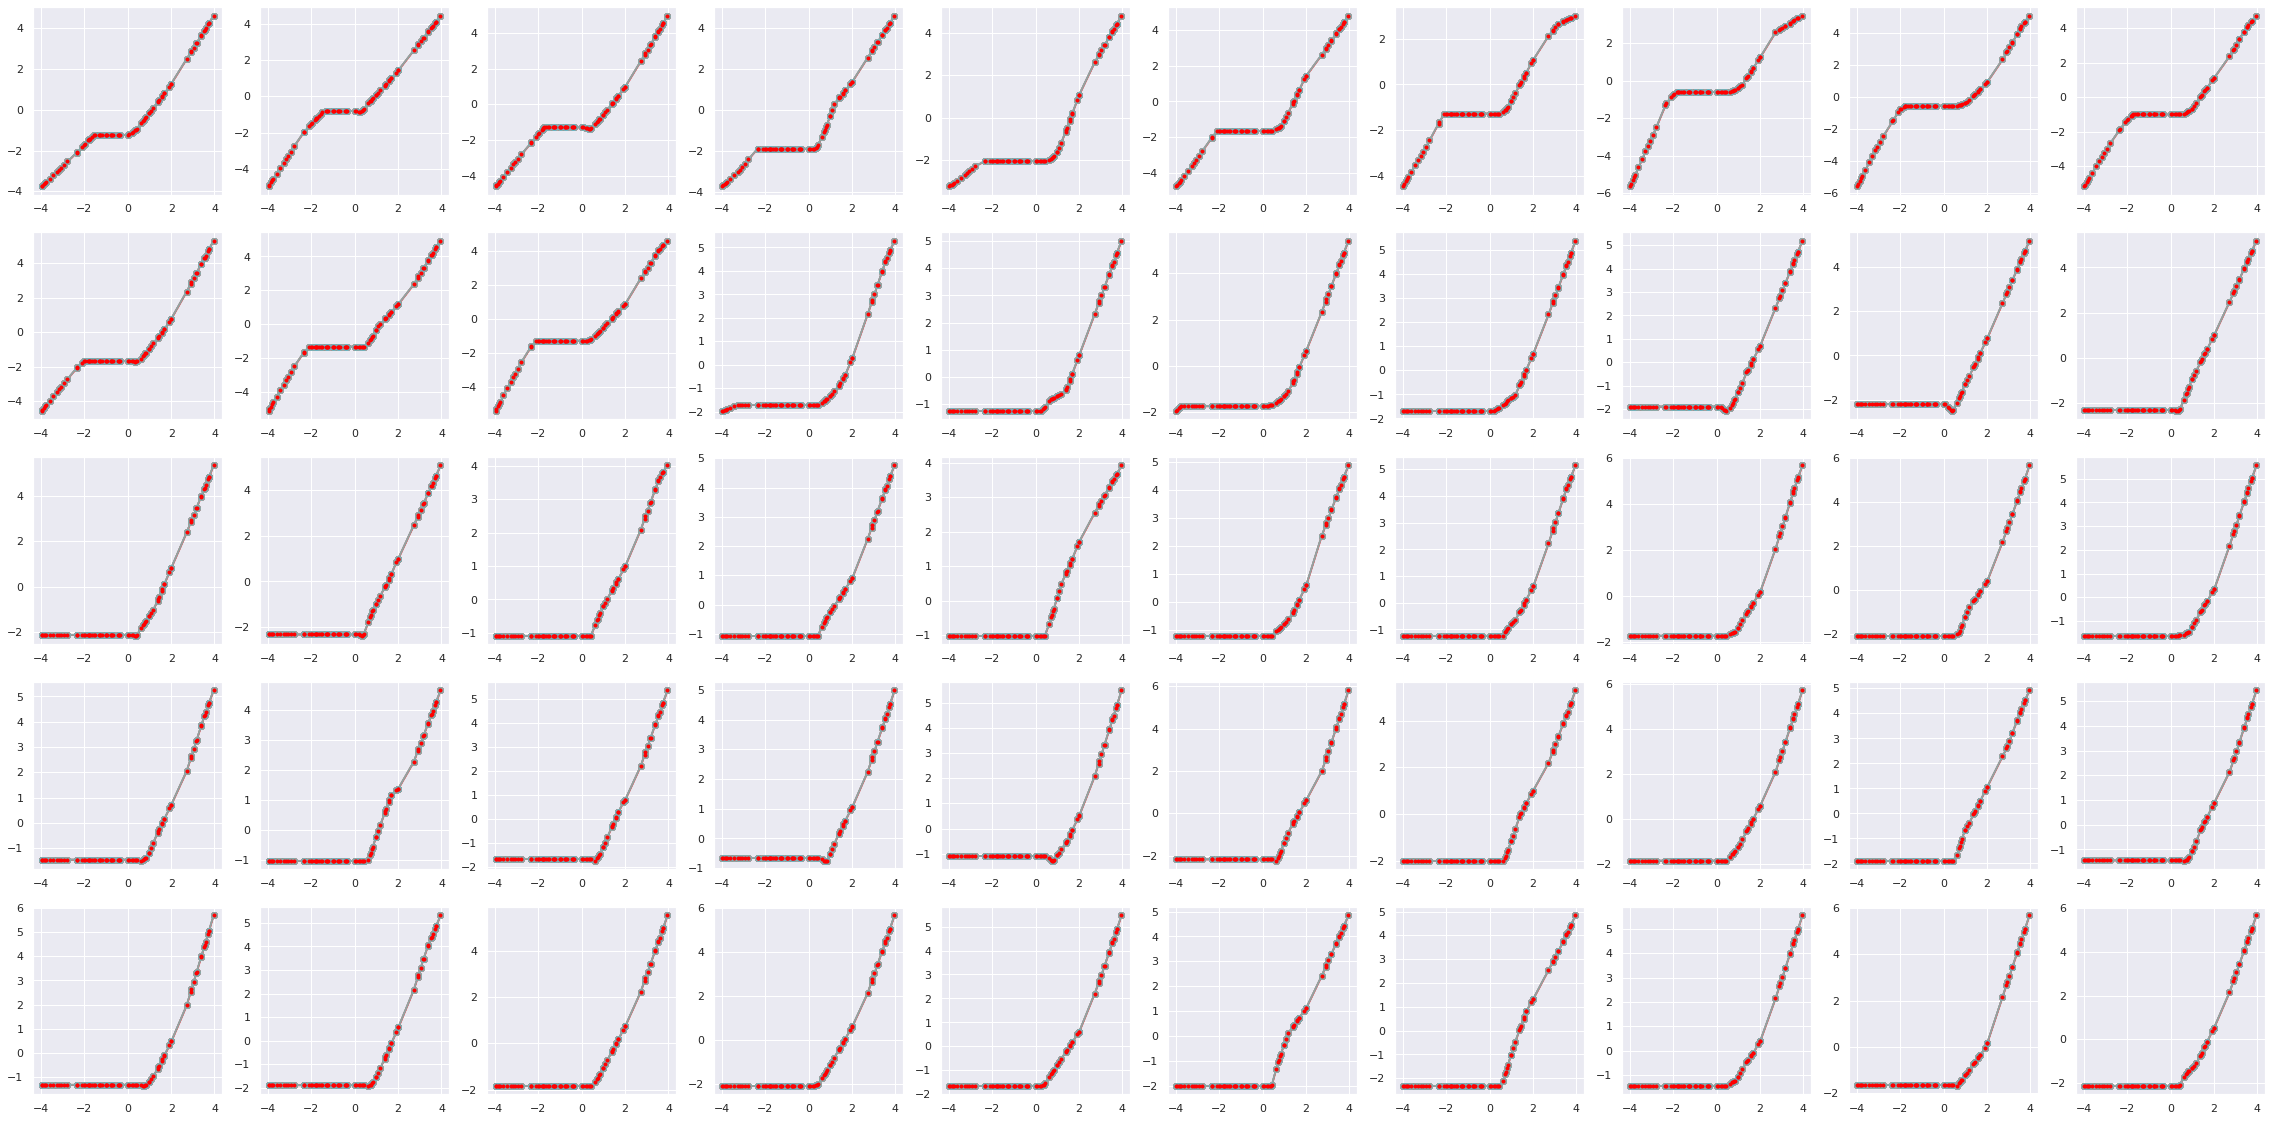

In [32]:
f, ax = plt.subplots(5,10, figsize=(40,20))
# sort_idx=np.argsort(test[0])
# x_test = test[0][sort_idx]
y_test=test[1][sort_idx]

for i in range(50):
    p = np.stack(preds[i], axis=0)
    mean = p.mean(axis=0)
    std = p.std(axis=0)
    y1=mean+2*std
    y2 = mean-2*std
    
    row = i//10
    col = i%10
#     ax[row,col].plot(x_test, y_test, 'o', color='red')
    for i in range(10):
        ax[row,col].plot(test[0][sort_idx], p[i], 'o-', alpha=0.4)
    ax[row,col].fill_between(test[0][sort_idx], y1, y2, color='red', alpha=0.4, label='mu with 2 std')
    ax[row, col].plot(test[0][sort_idx], mean, '.', color='red', label='mu')
    
plt.show()

**1.6** [2 pts] Compare both methods and discuss the pros and cons of each.


*Your answer here*

* Method 1: small variance but large bias

It seems that the first method has higher credibility for predictions (since the interval of mu with 2 stds is very small - almost zero), but the prediction doesn't really capture the trend when the training dataset is 'imperfect' (here train data has a gap between certain important intervals). When the dropout rate is larger, the trend gets lost more obviously (because important points standing for the trend are dropped out).

* Method 2: large variance but small bias

However, by using bootstrap and training 50 models, we found the 50 models have very different performance compared to the real trend. Even though the standard deviation of outputs from the 50 models is very large, the mean of the outputs does capture the real relationship between x and y even when the training set is imperfect.